# Homework 7: scikit-image

Due Tuesday Apr 10, 6pm

In [2]:
# Imports:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io

# Counting objects

In class, we saw how to count the number of objects in a microscopy image.  Here, we will repeat that exercise, but make use of some of the algorithms in `scikit-image` to segment the image, and then to determine properties of the resulting objects.

As input, use the image `skimage.data.coins`.  Segment the image, and then calculate the area and eccentricity of each coin.

There are various ways to do this.  One would be:

1. Equalize the input image (see `skimage.exposure`)
2. Threshold the image (`skimage.filters.otsu`)
3. Remove objects touching the boundary (`skimage.segmentation.clear_border`)
4. Apply morphological closing (`skimage.morphology.closing`)
5. Remove small objects (`skimage.measure.regionprops`).
   Visualize the results if you want with `skimage.color.label2rgb`.
7. Calculate the area and eccentricity of each coin, and display the
   original image with this information on it (`matplotlib.pyplot.text` or `matplotlib.pyplot.annotate`)

In [110]:
# Import skimage packages:
from skimage import exposure, filters, segmentation, morphology, measure, color, data
#import skimage.exposure as exposure
#import skimage.filters as filters
#import skimage.segmentation as seg
#import skimage.morphology as morph
#import skimage.measure as measure
#import skimage.color as color

# Bring in data:
#import skimage.data as data

In [75]:
# Read in image from data
img = data.coins()

# Equalize.
img_eq = exposure.equalize_adapthist(img)

# Threshold.
thresh = filters.threshold_otsu(img_eq)
img_th = img_eq >= thresh

# Remove objects near border.
img_border = segmentation.clear_border(img_th)

# 'Close' the image. This should remove black dots and smooth out the coins.
img_closed = morphology.closing(img_border)#,selem=np.ones((6,6)))

# Remove other small objects and get labels. From labels get properties.
labels = measure.label(img_closed)
properties = measure.regionprops(labels,img)
# From properties we care about centroid (center of circle), eccentricity, and area.

Text(0.5,1,'Labeled image')

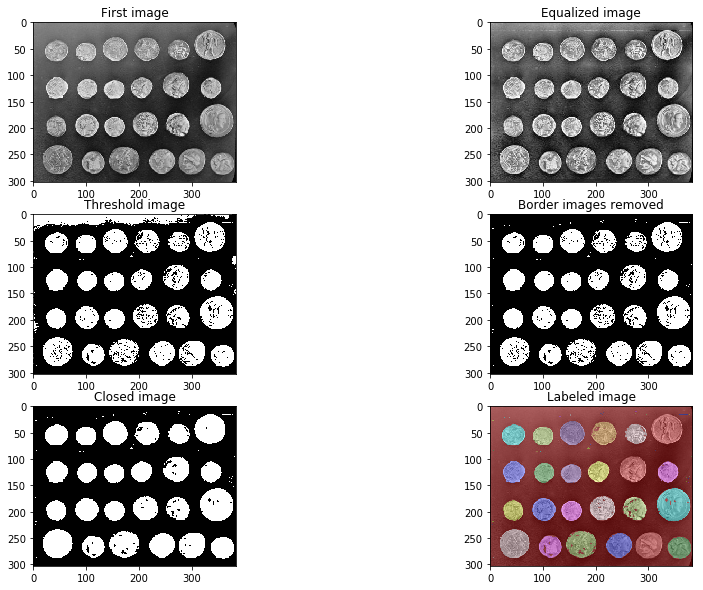

In [80]:
# Plot each step:
fig, axes = plt.subplots(3,2, figsize = (15,10))
axes[0,0].imshow(img,cmap='gray')
axes[0,0].set_title('First image')
axes[0,1].imshow(img_eq,cmap='gray')
axes[0,1].set_title('Equalized image')
axes[1,0].imshow(img_th,cmap='gray')
axes[1,0].set_title('Threshold image')
axes[1,1].imshow(img_border,cmap='gray')
axes[1,1].set_title('Border images removed')
axes[2,0].imshow(img_closed,cmap='gray')
axes[2,0].set_title('Closed image')
axes[2,1].imshow(color.label2rgb(labels,img))
axes[2,1].set_title('Labeled image')

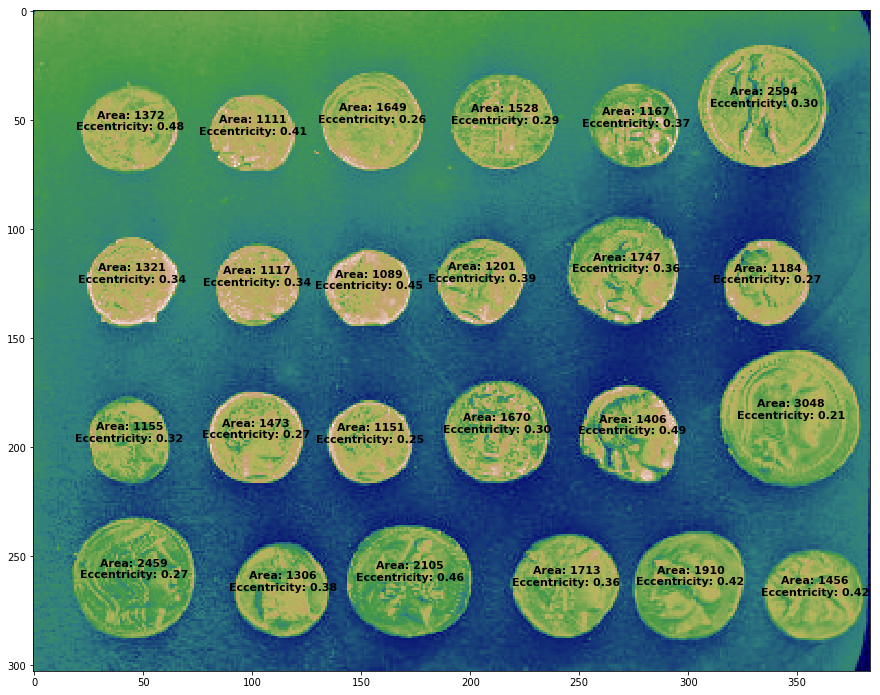

In [109]:
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(img,cmap='gist_earth')
for prop in properties:
    # Loop through the properties, but ignore the small points (ie. only put the area and eccentricity for the coins)
    if prop.area > 50:
        plt.text(prop.centroid[1],prop.centroid[0],
                 "Area: {}\nEccentricity: {:.2f}".format(prop.area,prop.eccentricity),
                 horizontalalignment='center', fontsize=11, weight='semibold')

# Panorama stitching

One of the scikit-image tutorials shows [how to do panorama stitching](https://github.com/scikit-image/skimage-tutorials/blob/master/lectures/solutions/adv3_panorama-stitching-solution.ipynb).

Take 3 or 4 overlapping photos of your own, and use the procedure described to stitch your own panorama.

In [3]:
# I'm going to want to compare images at several points, so let's steal this function:
def compare(*images, **kwargs):
    """
    Utility function to display images side by side.
    
    Parameters
    ----------
    image0, image1, image2, ... : ndarrray
        Images to display.
    labels : list
        Labels for the different images.
    """
    f, axes = plt.subplots(1, len(images), **kwargs)
    axes = np.array(axes, ndmin=1)
    
    labels = kwargs.pop('labels', None)
    if labels is None:
        labels = [''] * len(images)
    
    for n, (image, label) in enumerate(zip(images, labels)):
        axes[n].imshow(image, interpolation='nearest', cmap='gray')
        axes[n].set_title(label)
        axes[n].axis('off')
    
    f.tight_layout()

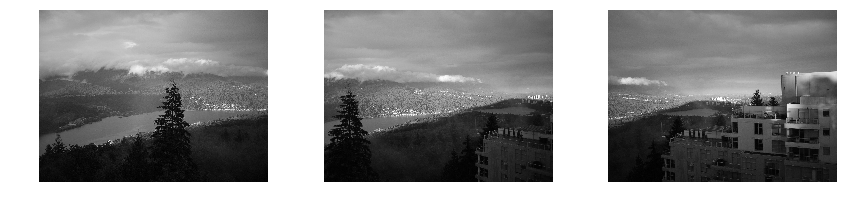

In [6]:
# Should be able to extend from P1070174.jpg to P1070169.jpg from my photos "View from Univercity" 
# This was my balcony in Vancouver!
# Since I will do a three image panorama, I just checked in these files to this directory to replicate easier.
pano_imgs = io.ImageCollection("./*.JPG")
# For some reason when this reads in it has length 6, but we actually only want 0,2,4. Fix that here, and switch to grayscale.
from skimage.color import rgb2gray
pano2 = rgb2gray(pano_imgs[0])
pano1 = rgb2gray(pano_imgs[2])
pano0 = rgb2gray(pano_imgs[4])

# Now plot using compare:
compare(pano0,pano1,pano2,figsize=(12,10))

### Feature detection

I will use the center image as an anchor and warp the other images into the center image. I will then detect features in all three images and match the outer two to the center one.

As in the example, I will use "Oriented FAST and rotated BRIEF" (ORB) to detect features.

In [7]:
from skimage.feature import ORB

# Initialize ORB
# 800 keypoints is large enough for robust results, 
# but low enough to run within a few seconds. 
# The default for fast_threshold is 0.08, but 0.05 will detect slightly more corners.
orb = ORB(n_keypoints=800, fast_threshold=0.05)

# Detect keypoints in pano0
orb.detect_and_extract(pano0)
keypoints0 = orb.keypoints
descriptors0 = orb.descriptors

# Detect keypoints in pano1
orb.detect_and_extract(pano1)
keypoints1 = orb.keypoints
descriptors1 = orb.descriptors

# Detect keypoints in pano2
orb.detect_and_extract(pano2)
keypoints2 = orb.keypoints
descriptors2 = orb.descriptors

In [8]:
from skimage.feature import match_descriptors

# Match descriptors between left/right images and the center
# Set cross check to true to return pairs.
matches01 = match_descriptors(descriptors0, descriptors1, cross_check=True)
matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)

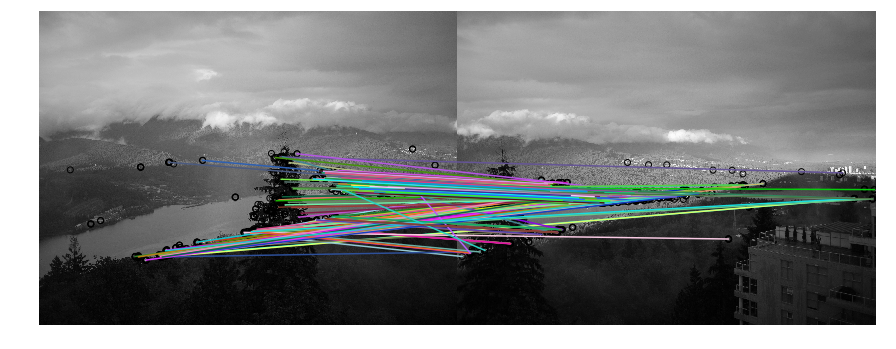

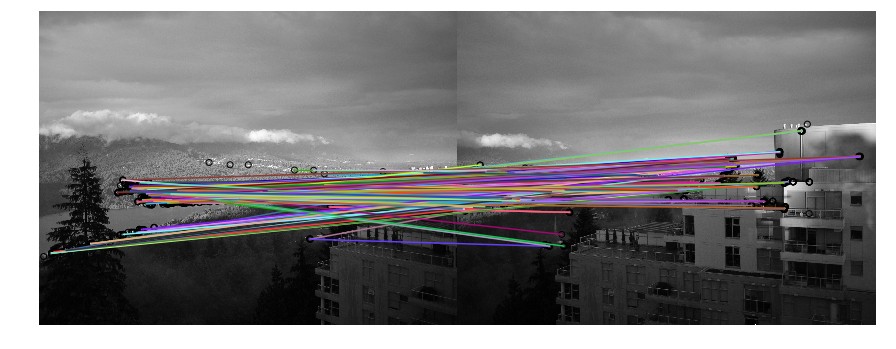

In [9]:
# This is just to plot to see the matched features:
from skimage.feature import plot_matches

# Best match subset for pano0 -> pano1
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
plot_matches(ax, pano0, pano1, keypoints0, keypoints1, matches01)
ax.axis('off');

# Best match subset for pano2 -> pano1
fig1, ax1 = plt.subplots(1, 1, figsize=(15, 12))
plot_matches(ax1, pano1, pano2, keypoints1, keypoints2, matches12)
ax1.axis('off');

We can see that some of these features are very well matched, but others are clearly wrong (they extend too far across the image or are mostly diagonal.)

### RANSAC to find best matches

Now we want to use RANSAC to filter out the bad matches and keep the good ones (reject outliers).

In [10]:
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac

# Select keypoints from 
#   * source (image to be registered): pano0
#   * target (reference image): pano1, our middle frame registration target
src = keypoints0[matches01[:, 0]][:, ::-1]
dst = keypoints1[matches01[:, 1]][:, ::-1]

model_robust01, inliers01 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=1, max_trials=300)

# Select keypoints from 
#   * source (image to be registered): pano2
#   * target (reference image): pano1, our middle frame registration target
src = keypoints2[matches12[:, 1]][:, ::-1]
dst = keypoints1[matches12[:, 0]][:, ::-1]

model_robust12, inliers12 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=1, max_trials=300)

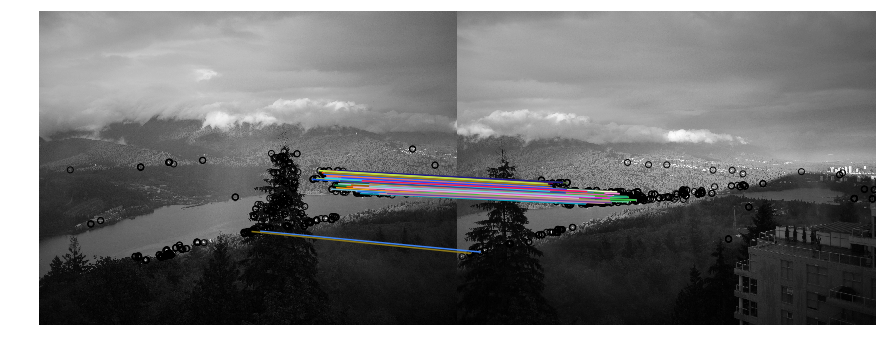

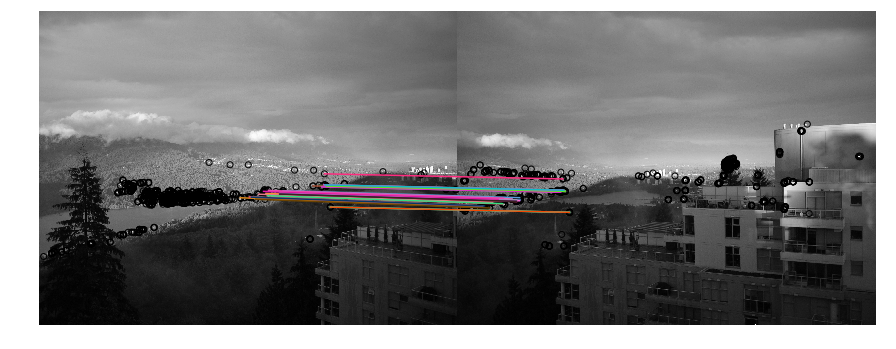

In [13]:
# Now that that's done let's look at the best matches that RANSAC chose:

# Best match subset for pano0 -> pano1
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
plot_matches(ax, pano0, pano1, keypoints0, keypoints1, matches01[inliers01])
ax.axis('off');

# Best match subset for pano2 -> pano1
fig1, ax1 = plt.subplots(1, 1, figsize=(15, 12))
plot_matches(ax1, pano1, pano2, keypoints1, keypoints2, matches12[inliers12])
ax1.axis('off');

# These clearly seemt to be much better!

### Warping the images

Now we actually want to match the images from the points we've found, so we have to warp the 0th and 2nd image.

In [16]:
# Find the appropriate output shape first:

from skimage.transform import SimilarityTransform

# Shape of middle image, our registration target
r, c = pano1.shape[:2]

# Note that transformations take coordinates in (x, y) format,
# not (row, column), in order to be consistent with most literature
corners = np.array([[0, 0],
                    [0, r],
                    [c, 0],
                    [c, r]])

# Warp the image corners to their new positions
# model_robust comes from ransac
warped_corners01 = model_robust01(corners)
warped_corners12 = model_robust12(corners)

# Find the extents of both the reference image and the warped
# target image
all_corners = np.vstack((warped_corners01, warped_corners12, corners))

# The overall output shape will be max - min
corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)
output_shape = (corner_max - corner_min)

# Ensure integer shape with np.ceil and dtype conversion
output_shape = np.ceil(output_shape[::-1]).astype(int)

In [17]:
# Warp the images. Note we also set values outside the initial images to -1 to tag them as background for later.

# Some transformation of pano1 is required even though it is the middle. 
# We have to place it in the middle of "output_shape".
from skimage.transform import warp

# This in-plane offset is the only necessary transformation for the middle image
offset1 = SimilarityTransform(translation= -corner_min)

# Translate pano1 into place
# Use a relatively high order (3/5) and set cval=-1 to set the background to -1.
# Note warp takes the inverse mapping as an input.
pano1_warped = warp(pano1, offset1.inverse, order=3,
                    output_shape=output_shape, cval=-1)

# Acquire the image mask for later use
pano1_mask = (pano1_warped != -1)  # Mask == 1 inside image
pano1_warped[~pano1_mask] = 0      # Return background values to 0

In [18]:
# Warp pano0 (left) to pano1. Use model from ransac and offset we found from before.
transform01 = (model_robust01 + offset1).inverse
pano0_warped = warp(pano0, transform01, order=3,
                    output_shape=output_shape, cval=-1)

# Get mask for later.
pano0_mask = (pano0_warped != -1)  # Mask == 1 inside image
pano0_warped[~pano0_mask] = 0      # Return background values to 0

In [19]:
# Warp pano2 (right) to pano1. Use model from ransac and offset we found from before.
transform12 = (model_robust12 + offset1).inverse
pano2_warped = warp(pano2, transform12, order=3,
                    output_shape=output_shape, cval=-1)

pano2_mask = (pano2_warped != -1)  # Mask == 1 inside image
pano2_warped[~pano2_mask] = 0      # Return background values to 0

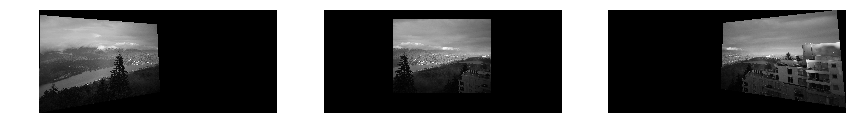

In [20]:
compare(pano0_warped, pano1_warped, pano2_warped, figsize=(12, 10));

### Combining images - First pass

This method just sums the images and normalizes. This will be terrible because when we normalize we will get very blurry images!

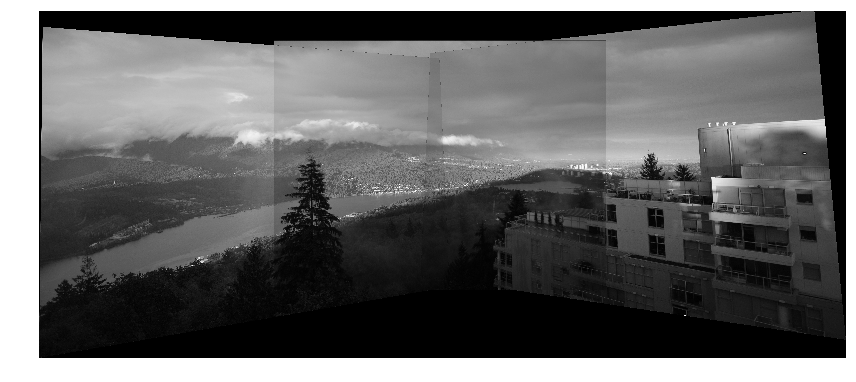

In [21]:
# Add the three images together. This could create dtype overflows!
# We know they are are floating point images after warping, so it's OK.
merged = (pano0_warped + pano1_warped + pano2_warped)


# Track the overlap by adding the masks together (this is why we kept masks)
overlap = (pano0_mask * 1.0 +  # Multiply by 1.0 for bool -> float conversion
           pano1_mask + 
           pano2_mask)

# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged / np.maximum(overlap, 1)

# View results
fig, ax = plt.subplots(figsize=(12, 12))

ax.imshow(normalized, cmap='gray')

plt.tight_layout()
ax.axis('off');

### Combining images - The better way

Above we can see that we ended up with dark lines where the images merged, which is a result of cval=-1 and looks bad. It's also blurry and not matched up well. It's really not great. Let's try to do it as recommended along a minimum-cost path!

It's generally a bad idea to blend pixels, so let's do away with that. Let's instead make a cost array and find the path that minimizes the sum of values along the path. We just need the cost array and beginning and ended points for the path.

In [22]:
# Define seed points:
ymax = output_shape[1] - 1
xmax = output_shape[0] - 1

# Start anywhere along the top and bottom, left of center.
mask_pts01 = [[0,    ymax // 3],
              [xmax, ymax // 3]]

# Start anywhere along the top and bottom, right of center.
mask_pts12 = [[0,    2*ymax // 3],
              [xmax, 2*ymax // 3]]

In [25]:
# Construct cost array by shamelessly stealing the defined function:
from skimage.measure import label

def generate_costs(diff_image, mask, vertical=True, gradient_cutoff=2.):
    """
    Ensures equal-cost paths from edges to region of interest.
    
    Parameters
    ----------
    diff_image : ndarray of floats
        Difference of two overlapping images.
    mask : ndarray of bools
        Mask representing the region of interest in ``diff_image``.
    vertical : bool
        Control operation orientation.
    gradient_cutoff : float
        Controls how far out of parallel lines can be to edges before
        correction is terminated. The default (2.) is good for most cases.
        
    Returns
    -------
    costs_arr : ndarray of floats
        Adjusted costs array, ready for use.
    """
    if vertical is not True:
        return tweak_costs(diff_image.T, mask.T, vertical=vertical,
                           gradient_cutoff=gradient_cutoff).T
    
    # Start with a high-cost array of 1's
    costs_arr = np.ones_like(diff_image)
    
    # Obtain extent of overlap
    row, col = mask.nonzero()
    cmin = col.min()
    cmax = col.max()

    # Label discrete regions
    cslice = slice(cmin, cmax + 1)
    labels = label(mask[:, cslice])
    
    # Find distance from edge to region
    upper = (labels == 0).sum(axis=0)
    lower = (labels == 2).sum(axis=0)
    
    # Reject areas of high change
    ugood = np.abs(np.gradient(upper)) < gradient_cutoff
    lgood = np.abs(np.gradient(lower)) < gradient_cutoff
    
    # Give areas slightly farther from edge a cost break
    costs_upper = np.ones_like(upper, dtype=np.float64)
    costs_lower = np.ones_like(lower, dtype=np.float64)
    costs_upper[ugood] = upper.min() / np.maximum(upper[ugood], 1)
    costs_lower[lgood] = lower.min() / np.maximum(lower[lgood], 1)
    
    # Expand from 1d back to 2d
    vdist = mask.shape[0]
    costs_upper = costs_upper[np.newaxis, :].repeat(vdist, axis=0)
    costs_lower = costs_lower[np.newaxis, :].repeat(vdist, axis=0)
    
    # Place these in output array
    costs_arr[:, cslice] = costs_upper * (labels == 0)
    costs_arr[:, cslice] +=  costs_lower * (labels == 2)
    
    # Finally, place the difference image
    costs_arr[mask] = diff_image[mask]
    
    return costs_arr

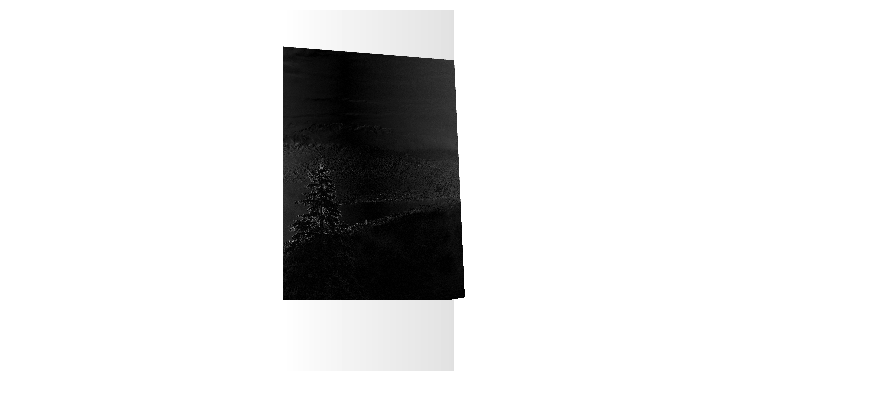

In [27]:
# Find the cost array in our case, for the first two images:

# Start with the absolute value of the difference image.
# np.abs is necessary because we don't want negative costs!
costs01 = generate_costs(np.abs(pano0_warped - pano1_warped),
                         pano0_mask & pano1_mask)

# Since we want any point along the top to be OK as the seed,
# allow the path to "slide" along top and bottom edges to the optimal horizontal position.
# Do this by setting top and bottom edges to zero cost.
costs01[0,  :] = 0
costs01[-1, :] = 0

# Plot the cost array:
fig, ax = plt.subplots(figsize=(15, 12))
ax.imshow(costs01, cmap='gray', interpolation='none')
ax.axis('off');

In [28]:
# The cost break away from the edge is to prevent the path from just being along one edge.
# Now find the minimum cost path through the overlapping region:

from skimage.graph import route_through_array

# Arguments are:
#   cost array
#   start pt
#   end pt
#   can it traverse diagonally
pts, _ = route_through_array(costs01, mask_pts01[0], mask_pts01[1], fully_connected=True)

# Convert list of lists to 2d coordinate array for easier indexing
pts = np.array(pts)

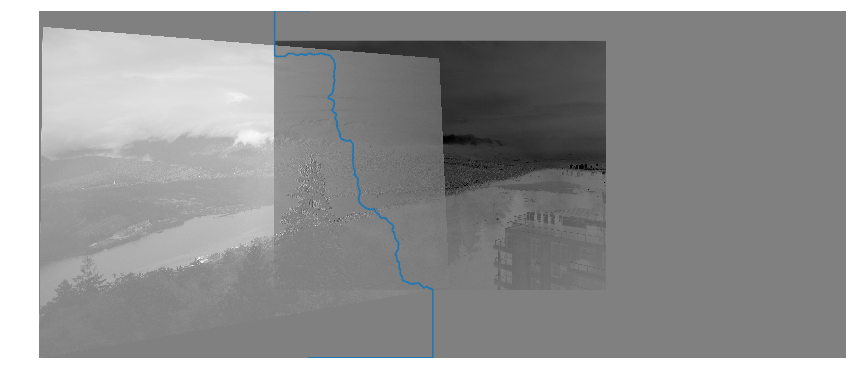

In [31]:
# Check if it worked:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the difference image
ax.imshow(pano0_warped - pano1_warped, cmap='gray')

# Overlay the minimum-cost path
ax.plot(pts[:, 1], pts[:, 0])  

plt.tight_layout()
ax.axis('off');

# Note that along the path, the value is close to 0 (which is the grey background). 
# This will prevent us from having the weird overlap!

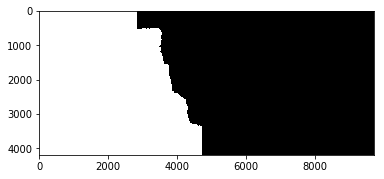

In [34]:
# Now define a mask so that to the left of this seam we use the first image, 
# and to the right of it we use the center image:
# Start with an array of zeros and place the path
mask0 = np.zeros_like(pano0_warped, dtype=np.uint8)
mask0[pts[:, 0], pts[:, 1]] = 1

# Check to make sure it lines up:
from skimage.measure import label
# Labeling starts with one at point (0, 0)
mask0 = (label(mask0, connectivity=1, background=-1) == 1)
# The result
plt.imshow(mask0, cmap='gray');

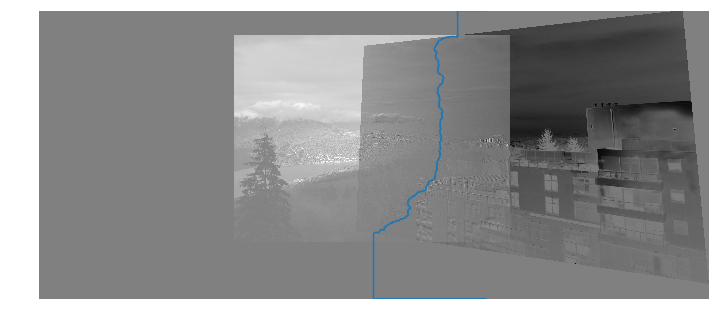

In [36]:
# Now do the same thing with the other image!

# Start with the absolute value of the difference image.
# np.abs necessary because we don't want negative costs!
costs12 = generate_costs(np.abs(pano1_warped - pano2_warped),
                         pano1_mask & pano2_mask)

# Allow the path to "slide" along top and bottom edges to the optimal 
# horizontal position by setting top and bottom edges to zero cost
costs12[0,  :] = 0
costs12[-1, :] = 0

# This time, we need to make sure our paths don't cross, so add this constraint:
costs12[mask0 > 0] = 1

# Compute minimum path
# Arguments are:
#   cost array
#   start pt
#   end pt
#   can it traverse diagonally
pts, _ = route_through_array(costs12, mask_pts12[0], mask_pts12[1], fully_connected=True)

# Convert list of lists to 2d coordinate array for easier indexing
pts = np.array(pts)

# Double check it is sane:
fig, ax = plt.subplots(figsize=(12, 12))
# Plot the difference image
ax.imshow(pano1_warped - pano2_warped, cmap='gray')
# Overlay the minimum-cost path
ax.plot(pts[:, 1], pts[:, 0]);
ax.axis('off');

# Make the mask again:
mask2 = np.zeros_like(pano0_warped, dtype=np.uint8)
mask2[pts[:, 0], pts[:, 1]] = 1
# And this time fill the right hand side.
mask2 = (label(mask2, connectivity=1, background=-1) == 3)

In [38]:
# Now we need to find the mask for the middle image:
mask1 = ~(mask0 | mask2).astype(bool)

In [39]:
# Define a function to put the masks in the alpha channels for all the images.
def add_alpha(img, mask=None):
    """
    Adds a masked alpha channel to an image.
    
    Parameters
    ----------
    img : (M, N[, 3]) ndarray
        Image data, should be rank-2 or rank-3 with RGB channels
    mask : (M, N[, 3]) ndarray, optional
        Mask to be applied. If None, the alpha channel is added
        with full opacity assumed (1) at all locations.
    """
    from skimage.color import gray2rgb
    if mask is None:
        mask = np.ones_like(img)
        
    if img.ndim == 2:
        img = gray2rgb(img)
    
    return np.dstack((img, mask))

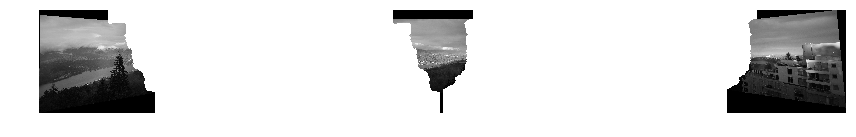

In [40]:
# Use the add_alpha function to get the final images:
pano0_final = add_alpha(pano0_warped, mask0)
pano1_final = add_alpha(pano1_warped, mask1)
pano2_final = add_alpha(pano2_warped, mask2)

compare(pano0_final, pano1_final, pano2_final, figsize=(12, 12))

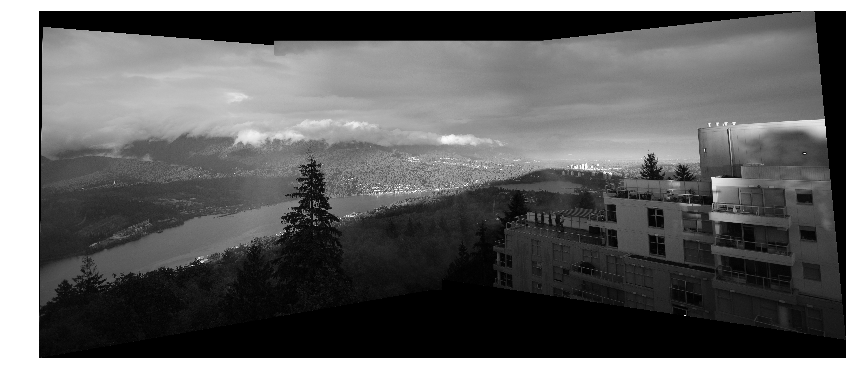

In [41]:
# Finally add them all together!
fig, ax = plt.subplots(figsize=(12, 12))

# This is a perfect combination, but matplotlib's interpolation
# makes it appear to have gaps. So we turn it off.
ax.imshow(pano0_final, interpolation='none')
ax.imshow(pano1_final, interpolation='none')
ax.imshow(pano2_final, interpolation='none')

fig.tight_layout()
ax.axis('off');

### Add colour back!
We still want to have colour images so let's go back and fix that. Since we have all the transforms and masks we just transform the colour images instead.

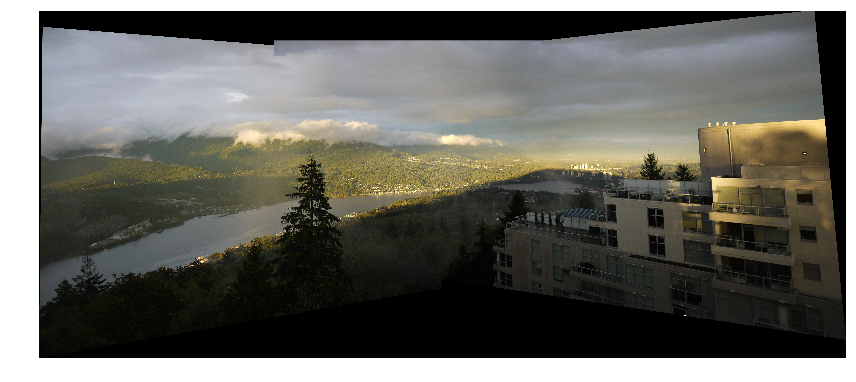

In [45]:
# Identical transforms as before, except
#   * Operating on original color images
#   * filling with cval=0 as we know the masks
pano0_color = warp(pano_imgs[4], (model_robust01 + offset1).inverse, order=3,
                   output_shape=output_shape, cval=0)

pano1_color = warp(pano_imgs[2], offset1.inverse, order=3,
                   output_shape=output_shape, cval=0)

pano2_color = warp(pano_imgs[0], (model_robust12 + offset1).inverse, order=3,
                   output_shape=output_shape, cval=0)

# Add the alpha channels
pano0_final_c = add_alpha(pano0_color, mask0)
pano1_final_c = add_alpha(pano1_color, mask1)
pano2_final_c = add_alpha(pano2_color, mask2)

# View
fig, ax = plt.subplots(figsize=(12, 12))
# Turn off matplotlib's interpolation
ax.imshow(pano0_final_c, interpolation='none')
ax.imshow(pano1_final_c, interpolation='none')
ax.imshow(pano2_final_c, interpolation='none')
fig.tight_layout()
ax.axis('off');

In [46]:
# Save the image!
from skimage.color import gray2rgb

# Start with empty image
pano_combined = np.zeros_like(pano0_color)

# Place the masked portion of each image into the array
# masks are 2d, they need to be (M, N, 3) to match the color images
pano_combined += pano0_color * gray2rgb(mask0)
pano_combined += pano1_color * gray2rgb(mask1)
pano_combined += pano2_color * gray2rgb(mask2)


# Save the output - precision loss warning is expected
# moving from floating point -> uint8
io.imsave('./pano-advanced-output.png', pano_combined)

/Users/micbru/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


## Extra: Image Stacking

Reprocess one of the datasets from http://www.rawastrodata.com/.  See http://www.rawastrodata.com/pages/typesofimages.html for a description of the different kind of images.